# PET deconvolution Exercise

1. Use STIR's `find_fwhm_in_image` utility to estimate the point spread function (PSF) using the point source measurement


2. Use this PSF to deconvolve the OSEM reconstruction with the Richardson-Lucy (RL) algorithm

3. RL can result in noise amplification. Use a CIL algorithm (we recommend PDHG) to do total variation (TV) regularised deconvolution


4. Image guidance can improve the accuracy of reconstructions/deconvolutions. Use the T1 MRI image as guidance for deconvolution by implementing a directional TV. 


5. Proximal algorithms such as TV are used when our objective function in non-differentiable. TV (and it's directional counterpart) can be smoothed and then used with gradient-based algorithms. Implement a preconditioned gradient descent algorithm using directional TV as a prior. Does this improve the convergence properties? Does smoothing the prior effect the solution?

In [1]:
import numpy as np
import os
import subprocess
import re
import matplotlib.pyplot as plt

import sirf.STIR as pet

from cil.utilities.display import show2D
from cil.optimisation.operators import  BlurringOperator

import cil.optimisation.operators as op
import cil.optimisation.algorithms as alg
import cil.optimisation.functions as fn
import cil.framework as cil

msg = pet.MessageRedirector()

In [2]:
def make_acquisition_model(template_sinogram, template_image, atten_image):

    # We'll start by initialising the acquisition model object
    acq_model = pet.AcquisitionModelUsingRayTracingMatrix()
    acq_model.set_num_tangential_LORs(10) 

    # In order to create LOR attenuation coefficients, we need to project the attenuation image into sinogram space
    acq_asm = pet.AcquisitionModelUsingRayTracingMatrix()
    acq_asm.set_num_tangential_LORs(10)
    acq_model.set_acquisition_sensitivity(pet.AcquisitionSensitivityModel(atten_image, acq_asm))

    # And finally, we can set up the acquisition model
    acq_model.set_up(template_sinogram,template_image)

    return acq_model

In [3]:
noise_seed = 5
bw_seed = 1337

In [4]:
image_list = ['PET', 'T1', 'uMap']
image_dict = {}
for image in image_list:
    image_dict[image] = pet.ImageData(os.path.join('data', f'{image}_b{bw_seed}.hv'))
image_dict['OSEM'] = pet.ImageData(os.path.join('data', f'OSEM_b{bw_seed}_n{noise_seed}.hv'))
image_dict['OSEM_psf'] = pet.ImageData(os.path.join('data', f'OSEM_psf_n{noise_seed}.hv'))

In [5]:
def find_fwhm_in_image(file_path):
    # Run the command
    result = subprocess.run(['find_fwhm_in_image', file_path], capture_output=True, text=True)

    # Check for errors
    if result.returncode != 0:
        print("Error running command:", result.stderr)
        return None

    # Regular expression to find FWHM values in the output
    fwhm_regex = r"The resolution in (.*) axis is ([\d.]+)"
    
    # Find all matches
    matches = re.findall(fwhm_regex, result.stdout)

    # Convert matches to a dictionary
    fwhm_values = {axis: float(value) for axis, value in matches}
    
    return fwhm_values

fwhm = list(find_fwhm_in_image(os.path.join('data', f'OSEM_psf_n{noise_seed}.hv')).values())
print(f'FWHM: {fwhm}')

FWHM: [7.78395, 6.72673, 6.91054]


In [6]:
def fwhm_to_sigma(fwhm):
    return fwhm / (2 * np.sqrt(2 * np.log(2)))

def psf(n, fwhm, voxel_size=(1, 1, 1)):
    """ Creates a 3D point spread function (PSF) with specified sizes `n`, FWHM values `fwhm`, and voxel sizes `voxel_size` """

    sigma_voxels = [fwhm_to_sigma(fwhm[i]) / voxel_size[i] for i in range(3)]
    
    # Create Gaussian distributions for each dimension
    axes = [np.linspace(-(n - 1) / 2., (n - 1) / 2., n) for i in range(3)]
    gauss = [np.exp(-0.5 * np.square(ax) / np.square(sigma_voxels[i])) for i, ax in enumerate(axes)]

    # Create 3D Gaussian kernel
    kernel_3d = np.outer(gauss[0], gauss[1]).reshape(n, n, 1) * gauss[2].reshape(1, 1, n)
    
    # Normalize the kernel to ensure its sum equals one
    return kernel_3d / np.sum(kernel_3d)

In [7]:
PSF=psf(5, fwhm=fwhm, voxel_size=image_dict['OSEM'].voxel_sizes())
convolve=BlurringOperator(PSF, image_dict['PET'])

## Richardson-Lucy algorithm

If you understand MLEM, you understand RL. The RL update for image $u$ is:

$$ x^{(n+1)} = x^{(n)} \odot C^\dagger \ast \frac{x_j^{(0)}}{C \ast x_j^{(n)}} $$

where we $C$ is our convolution kernel and $\odot$, $\ast$ denote the hadamard (element-wise) product and convolutional operators

In [8]:
def RL(initial, convolution, iterations, eta=1e-6):

    objective_values = []

    current_estimate = initial.clone()

    for i in range(iterations):
        current_estimate*= convolution.adjoint(initial/(convolution.direct(current_estimate)+eta))
        convolved_estimate = convolution.direct(current_estimate)
        objective_values.append(convolved_estimate.sum() - (initial * (convolved_estimate+eta).log()).sum())

        print(f"Iteration: {i}, Objective: {objective_values[-1]}", end = '\r')

    return current_estimate, objective_values

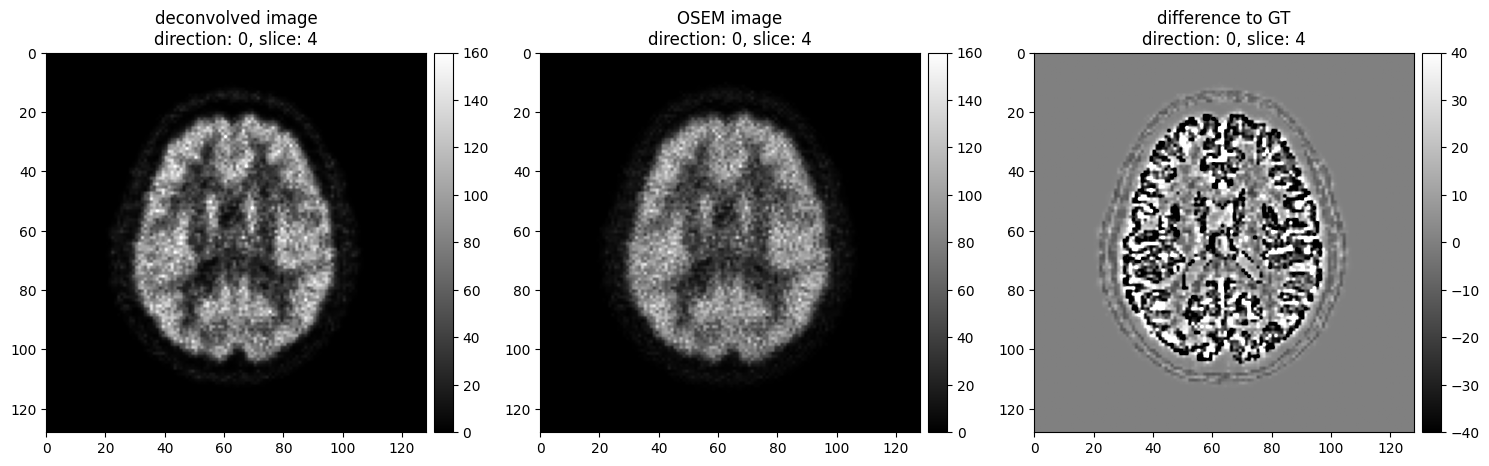

Text(0, 0.5, 'Objective Function Value')

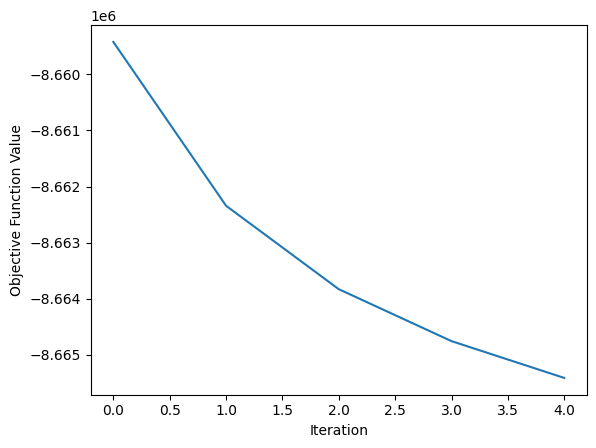

In [9]:
deconvolved_5iter, obj_5iter = RL(image_dict['OSEM'], convolve, 5)

show2D([deconvolved_5iter, image_dict['OSEM'], deconvolved_5iter-image_dict['PET']], 
       title = ['deconvolved image', 'OSEM image', 'difference to GT'], 
       origin = 'upper', num_cols = 3, fix_range=[(0,160), (0,160), (-40,40)],)

plt.plot(obj_5iter)   
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

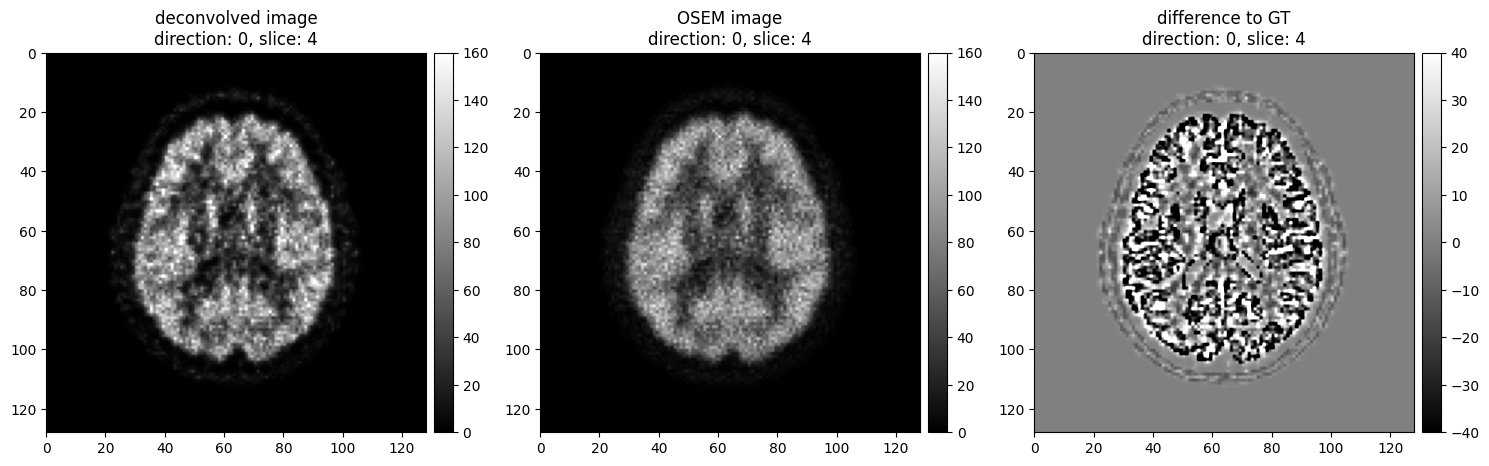

Text(0, 0.5, 'Objective Function Value')

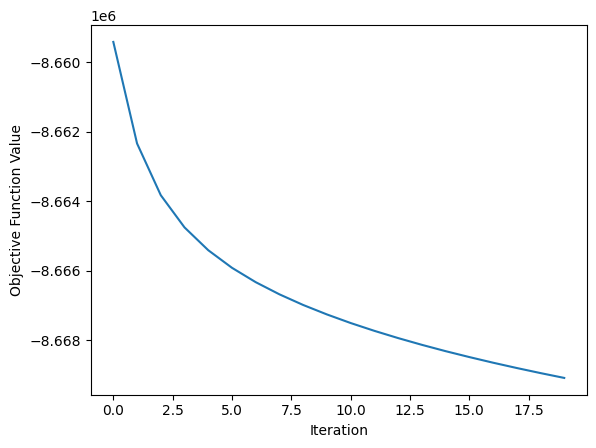

In [10]:
deconvolved_20iter, obj_20iter = RL(image_dict['OSEM'], convolve, 20)

show2D([deconvolved_20iter, image_dict['OSEM'], deconvolved_20iter-image_dict['PET']], 
       title = ['deconvolved image', 'OSEM image', 'difference to GT'], 
       origin = 'upper', num_cols = 3, fix_range=[(0,160), (0,160), (-40,40)],)

plt.plot(obj_20iter)   
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

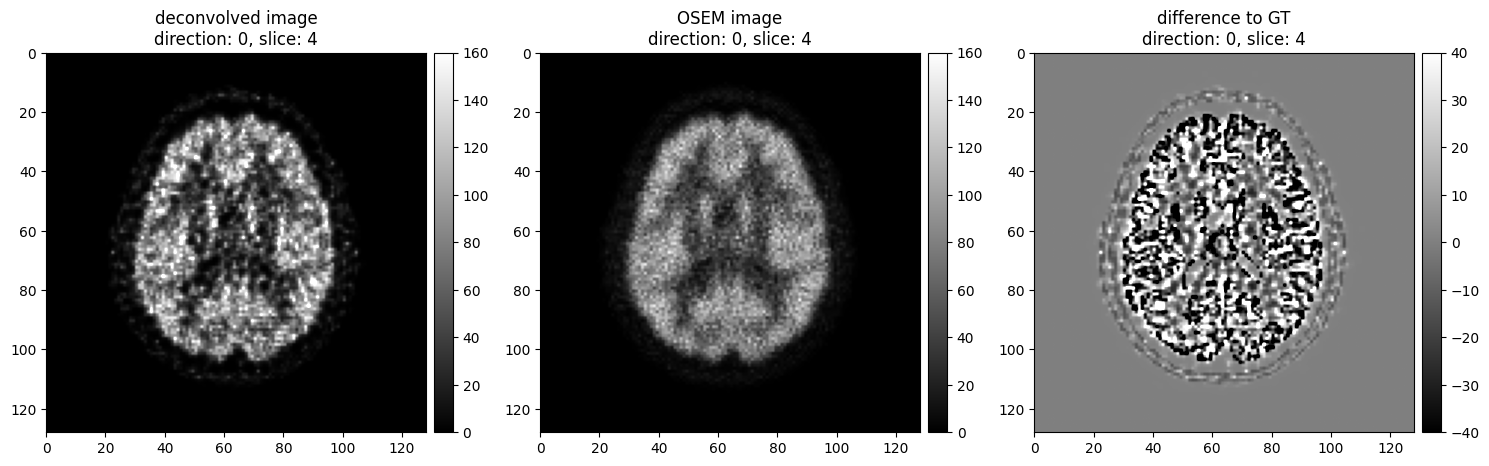

Text(0, 0.5, 'Objective Function Value')

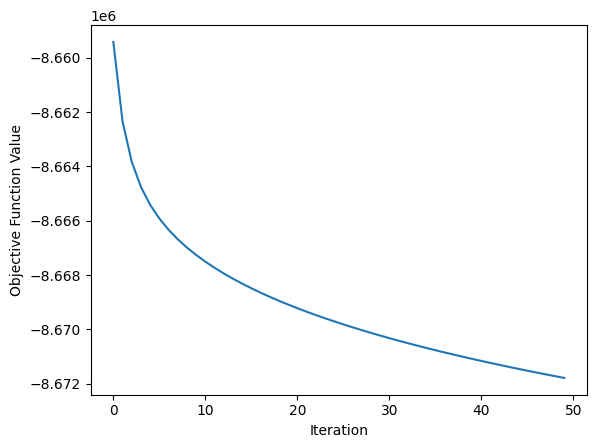

In [11]:
deconvolved_50iter, obj_50iter = RL(image_dict['OSEM'], convolve, 80)

show2D([deconvolved_50iter, image_dict['OSEM'], deconvolved_50iter-image_dict['PET']], 
       title = ['deconvolved image', 'OSEM image', 'difference to GT'], 
       origin = 'upper', num_cols = 3, fix_range=[(0,160), (0,160), (-40,40)],)

plt.plot(obj_50iter)   
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

In [12]:
alpha = 0.02
f1 = fn.KullbackLeibler(b=image_dict['OSEM'], eta=image_dict['OSEM'].get_uniform_copy(1e-6))
f2 = alpha * fn.MixedL21Norm()
f = fn.BlockFunction(f1, f2)

g = fn.IndicatorBox(0)

grad = op.GradientOperator(image_dict['OSEM'])
K = op.BlockOperator(convolve, grad)

In [13]:
# Define the step sizes sigma and tau (these are by no means optimal)
normK = K.norm()
sigma = 1./normK
tau = 1./normK

In [14]:
# TODO: This monkey patching is a temporary solution to a bug in CIL

def update_previous_solution(self):
    tmp = self.x_old
    self.x_old = self.x
    self.x = tmp

alg.PDHG.update_previous_solution = update_previous_solution

In [15]:
pdhg = alg.PDHG(f = f, g = g, operator = K, tau = 0.99*tau, sigma = 0.99*sigma, initial=image_dict['OSEM']
,max_iteration = 500, update_objective_interval = 50, check_convergence=False)


In [16]:
pdhg.run(verbose=1)


     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        500         0.000          1.04954e+05
       50        500         0.842          9.71382e+04
      100        500         0.839          9.46749e+04
      150        500         0.838          9.31628e+04
      200        500         0.840          9.20611e+04
      250        500         0.842          9.11965e+04
      300        500         0.844          9.04887e+04
      350        500         0.844          8.98915e+04
      400        500         0.844          8.93779e+04
      450        500         0.845          8.89278e+04
      500        500         0.844          8.85288e+04
-------------------------------------------------------
      500        500         0.844          8.85288e+04
Stop criterion has been reached.



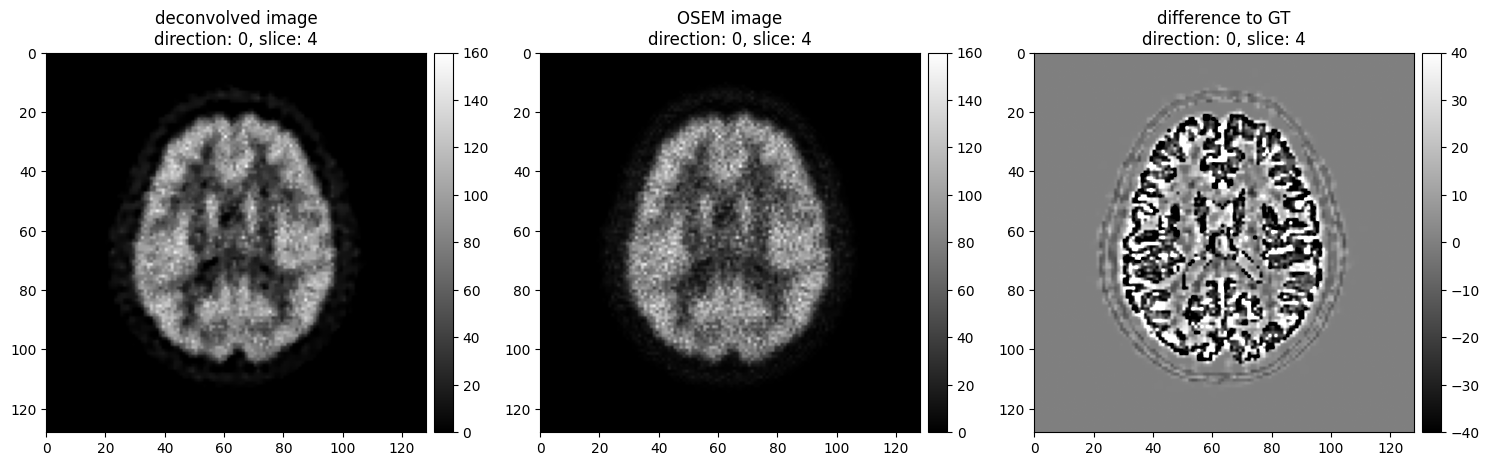

Text(0, 0.5, 'Objective Function Value')

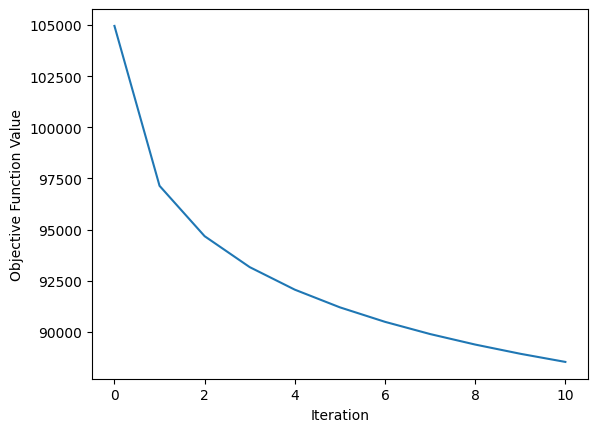

In [17]:
show2D([pdhg.solution, image_dict['OSEM'], pdhg.solution-image_dict['PET']],
         title = ['deconvolved image', 'OSEM image', 'difference to GT'], 
         origin = 'upper', num_cols = 3, fix_range=[(0,160), (0,160), (-40,40)],)

plt.plot(pdhg.objective)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

We use the directional total variation regulariser

$$g(x) =dTV:= \sum_i|D_i\nabla x_i|_2$$

 where the sum is over the pixels $i$ and where $D$ is a weighting vector filed on the gradient in $x$ dependent on the normalised gradient, $\zeta$,  of the reference image, $\nu$ so 
$$D=I-\zeta \zeta^T$$
and $$\zeta = -\dfrac{\nabla \nu }{\sqrt{\eta^2+|\nabla\nu|^2}}$$ where $0<\eta<<\|\nabla\nu\|$.


We can see that if $\nabla x= \gamma \nabla \nu$ then

 $$D\nabla x = \gamma D\nabla \nu= \gamma (I-\zeta \zeta^T)\nabla \nu= \gamma \left(\nabla \nu -\dfrac{\nabla \nu }{\sqrt{\eta^2+|\nabla\nu|^2}} \dfrac{\nabla \nu^T }{\sqrt{\eta^2+|\nabla\nu|^2}} \nabla \nu \right)=\gamma\nabla \nu \left(1-(1+\mathcal{O}(\frac{\eta^2}{\|\nabla\nu\|^2}) )\right) \approx 0.$$

We can also see if the gradient of the reconstructed image and the reference image are perpendicular, $\nabla x^T\nabla \nu=0$, then

$$D\nabla x (I-\zeta \zeta^T)\nabla x= \nabla \nu - \dfrac{\nabla \nu }{\sqrt{\eta^2+|\nabla\nu|^2}} \dfrac{\nabla \nu^T }{\sqrt{\eta^2+|\nabla\nu|^2}} \nabla x =\nabla \nu $$

 and is non-zero. 

This regulariser encourages the gradient of the reconstructed image to be equal to parallel to the gradient of the reference image. 

In [18]:
class DirectionalOperator(op.LinearOperator):

    def __init__(self, anatomical_gradient, gamma = 1, eta=1e-6):

        self.anatomical_gradient = anatomical_gradient
        geometry = cil.BlockGeometry(*[x for x in anatomical_gradient.containers])
        self.tmp = self.anatomical_gradient.containers[0].clone()

        self.gamma = gamma

        self.xi = self.anatomical_gradient/(self.anatomical_gradient.pnorm().power(2)+eta**2).sqrt()

        super(DirectionalOperator, self).__init__(domain_geometry=geometry,
                                       range_geometry=geometry,)
        
    def direct(self, x, out=None):

        if out is None:
            return x - self.gamma * self.xi * self.dot(self.xi, x)
        else:
            out.fill(x - self.gamma * self.xi * self.dot(self.xi, x))
    
    def adjoint(self, x, out=None):
        # This is the same as the direct operator
        return self.direct(x, out)
    
    def dot(self, x, y):
        self.tmp.fill(0)
        for el_x, el_y in zip(x.containers, y.containers):
            self.tmp += el_x * el_y
        return self.tmp
    

In [19]:
grad_ref = grad.direct(image_dict['T1'])
d_op = DirectionalOperator(grad_ref)

def calculate_norm(self):
    # return product of operator norms
    return np.prod([op.norm() for op in self.operators])
op.CompositionOperator.calculate_norm = calculate_norm

operator = op.CompositionOperator(d_op, grad)

Kd = op.BlockOperator(convolve, operator)

In [20]:
# Define the step sizes sigma and tau (these are by no means optimal)
normK = K.norm()
sigma = 1./normK
tau = 1./normK

In [21]:
pdhg_dtv = alg.PDHG(f = f, g = g, operator = Kd, tau = 0.99*tau, sigma = 0.99*sigma, initial=image_dict['OSEM'],
            max_iteration = 500, update_objective_interval = 50, check_convergence=False)

pdhg_dtv.run(verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        500         0.000          1.01551e+05
       50        500         1.923          9.37076e+04
      100        500         1.914          9.12464e+04
      150        500         1.915          8.97404e+04
      200        500         1.926          8.86422e+04
      250        500         1.926          8.77799e+04
      300        500         1.925          8.70734e+04
      350        500         1.923          8.64760e+04
      400        500         1.919          8.59600e+04
      450        500         1.914          8.55065e+04
      500        500         1.903          8.51028e+04
-------------------------------------------------------
      500        500         1.903          8.51028e+04
Stop criterion has been reached.



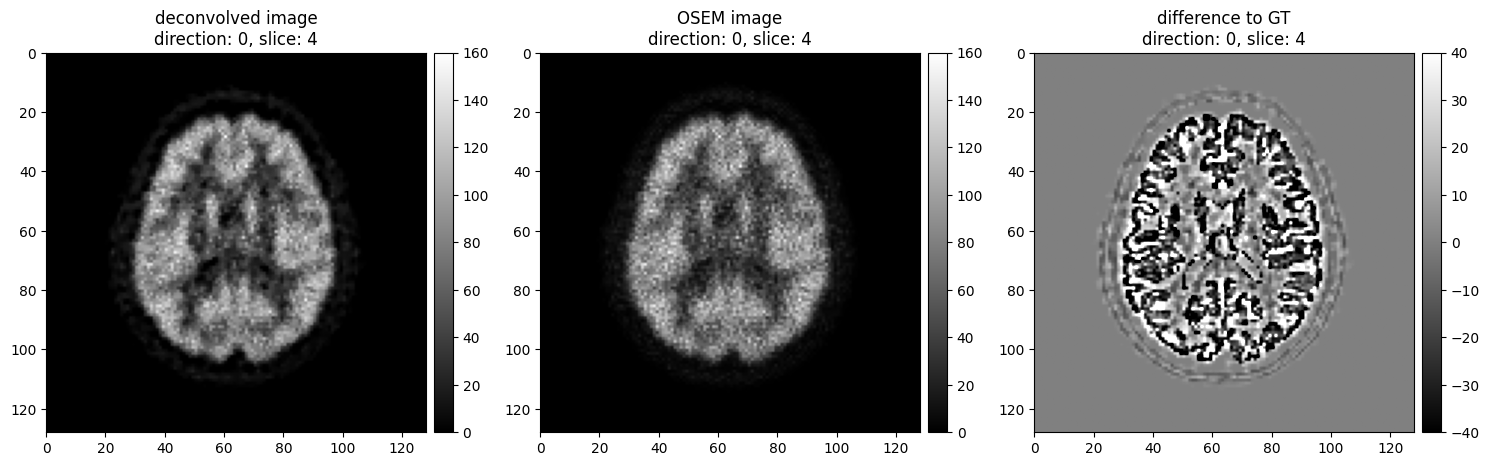

Text(0, 0.5, 'Objective Function Value')

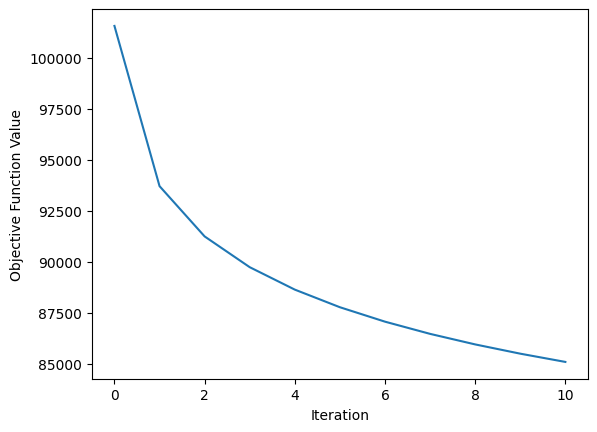

In [22]:
show2D([pdhg_dtv.solution, image_dict['OSEM'], pdhg_dtv.solution-image_dict['PET']],    
         title = ['deconvolved image', 'OSEM image', 'difference to GT'], 
         origin = 'upper', num_cols = 3, fix_range=[(0,160), (0,160), (-40,40)],)


plt.plot(pdhg_dtv.objective)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

In [23]:
class MAPRL(alg.Algorithm):

    def __init__(self, initial_estimate, data_fidelity, prior, step_size=1, relaxation_eta=0.01, eps=1e-8, **kwargs):

        self.initial_estimate = initial_estimate
        self.initial_step_size = step_size
        self.relaxation_eta = relaxation_eta
        self.eps = eps

        self.x = initial_estimate.clone()
        self.data_fidelity = data_fidelity
        self.prior = prior

        self.FOV_filter = pet.TruncateToCylinderProcessor()

        super(MAPRL, self).__init__(**kwargs)
        self.configured = True


    def step_size(self):
        return self.initial_step_size / (1 + self.relaxation_eta * self.iteration)
    
    def update(self):
        
        grad = self.data_fidelity.gradient(self.x) + self.prior.gradient(self.x)
        self.x = self.x - (self.x + self.eps) * grad * self.step_size()
        self.FOV_filter.apply(self.x)
        self.x.maximum(0, out=self.x)

    def update_objective(self):
        self.loss.append(self.data_fidelity(self.x) + self.prior(self.x))


In [24]:
data_fidelity = fn.OperatorCompositionFunction(f1, convolve)
prior = alpha * fn.OperatorCompositionFunction(fn.SmoothMixedL21Norm(epsilon=1e-4), grad)
prior_d = alpha * fn.OperatorCompositionFunction(fn.SmoothMixedL21Norm(epsilon=1e-4), operator)

In [25]:
maprl = MAPRL(initial_estimate=image_dict['OSEM'], data_fidelity=data_fidelity, prior=prior, 
              step_size=0.1, relaxation_eta=0.01, max_iteration=100, update_objective_interval=10)

In [26]:
maprl.run(verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          1.04954e+05
       10        100         0.897          9.87957e+04
       20        100         0.894          9.65490e+04
       30        100         0.890          9.53044e+04
       40        100         0.894          9.44849e+04
       50        100         0.898          9.38914e+04
       60        100         0.895          9.34347e+04
       70        100         0.895          9.30684e+04
       80        100         0.894          9.27655e+04
       90        100         0.892          9.25090e+04
      100        100         0.892          9.22879e+04
-------------------------------------------------------
      100        100         0.892          9.22879e+04
Stop criterion has been reached.



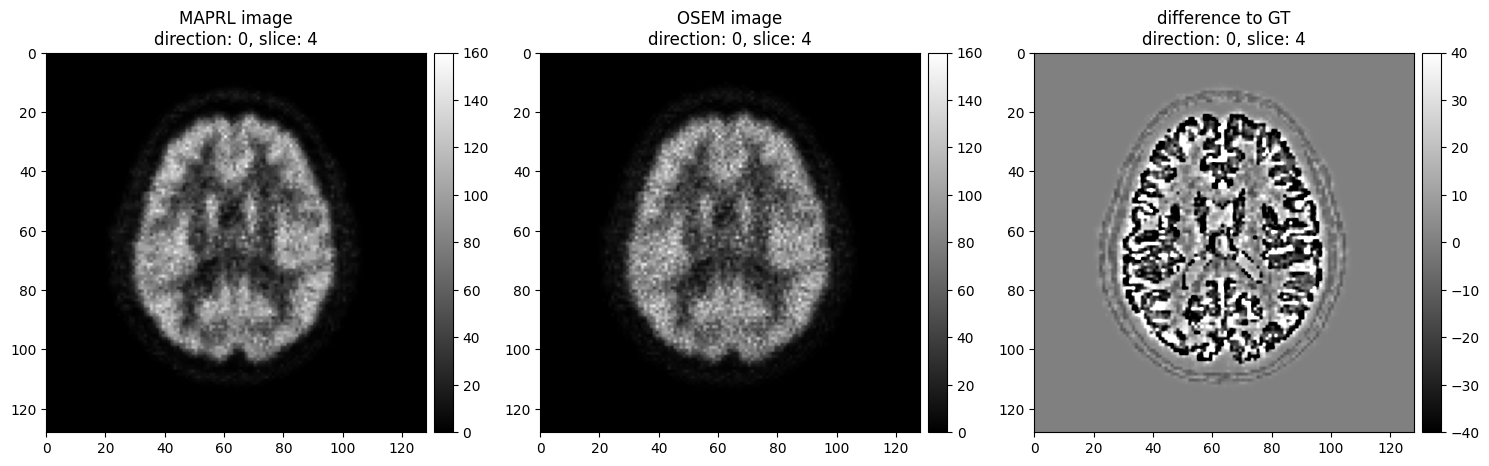

Text(0, 0.5, 'Objective Function Value')

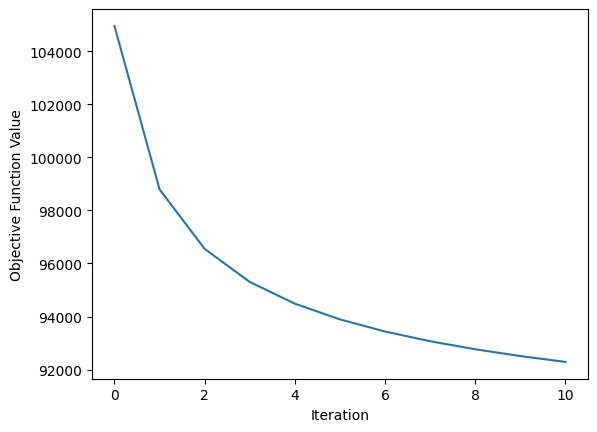

In [27]:
show2D([maprl.solution, image_dict['OSEM'], maprl.solution-image_dict['PET']],
         title = ['MAPRL image', 'OSEM image', 'difference to GT'], 
         origin = 'upper', num_cols = 3, fix_range=[(0,160), (0,160), (-40,40)],)

plt.plot(maprl.objective)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

In [28]:
maprl_dtv = MAPRL(initial_estimate=image_dict['OSEM'], data_fidelity=data_fidelity, prior=prior_d,
                step_size=0.1, relaxation_eta=0.01, max_iteration=100, update_objective_interval=10)

maprl_dtv.run(verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          1.01551e+05
       10        100         2.277          9.54334e+04
       20        100         2.280          9.32082e+04
       30        100         2.259          9.19786e+04
       40        100         2.250          9.11703e+04
       50        100         2.246          9.05858e+04
       60        100         2.232          9.01363e+04
       70        100         2.239          8.97761e+04
       80        100         2.244          8.94783e+04
       90        100         2.251          8.92263e+04
      100        100         2.239          8.90091e+04
-------------------------------------------------------
      100        100         2.239          8.90091e+04
Stop criterion has been reached.



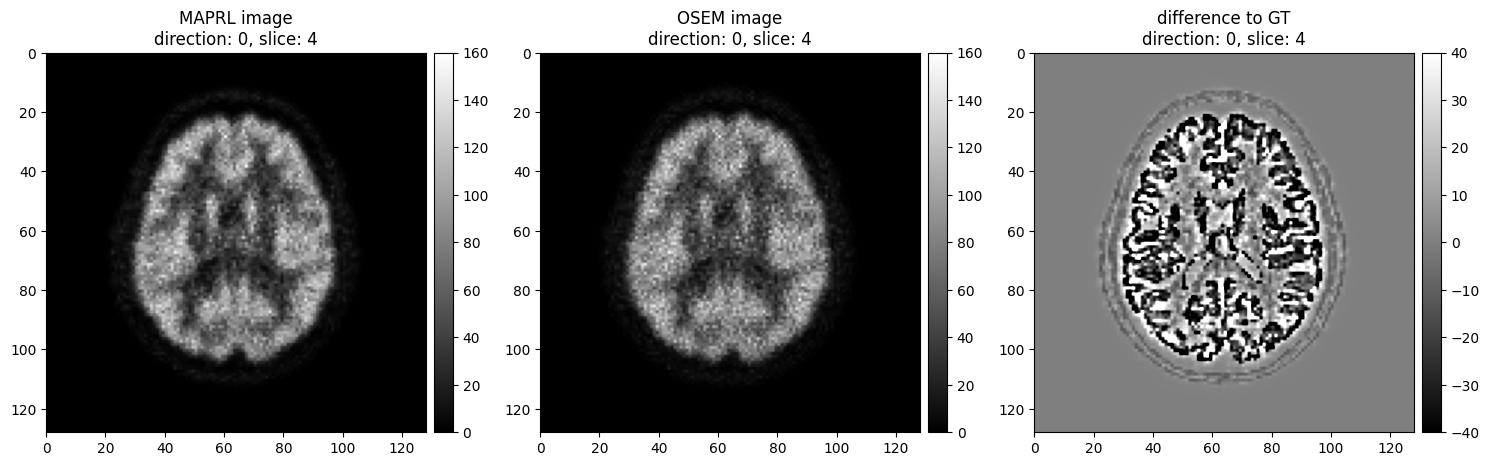

Text(0, 0.5, 'Objective Function Value')

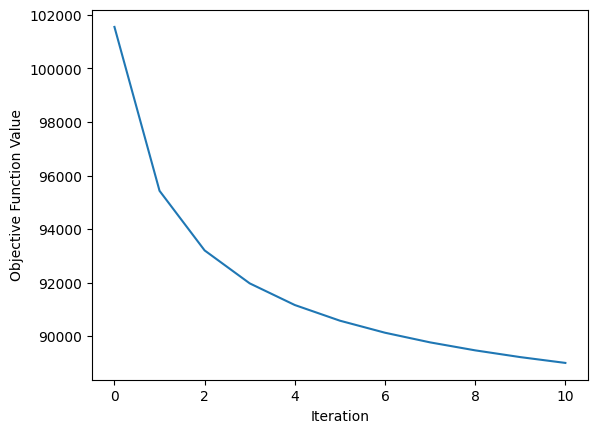

In [29]:
show2D([maprl_dtv.solution, image_dict['OSEM'], maprl_dtv.solution-image_dict['PET']],
            title = ['MAPRL image', 'OSEM image', 'difference to GT'], 
            origin = 'upper', num_cols = 3, fix_range=[(0,160), (0,160), (-40,40)],)

plt.plot(maprl_dtv.objective)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

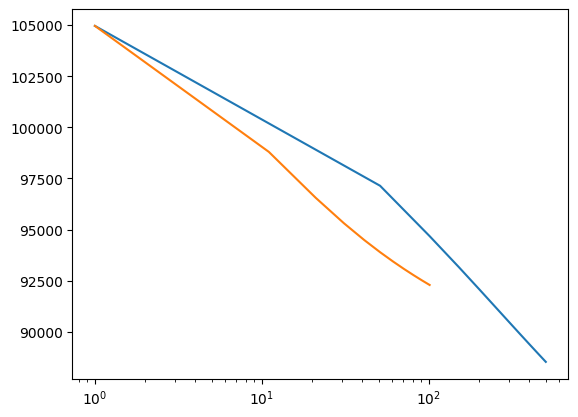

In [30]:
x_pdhg = np.arange(0, pdhg.iteration+1, pdhg.update_objective_interval)+1
x_maprl = np.arange(0, maprl.iteration+1, maprl.update_objective_interval)+1

plt.plot(x_pdhg, pdhg.objective, label='PDHG')
plt.plot(x_maprl, maprl.objective, label='MAPRL')

plt.xscale('log')

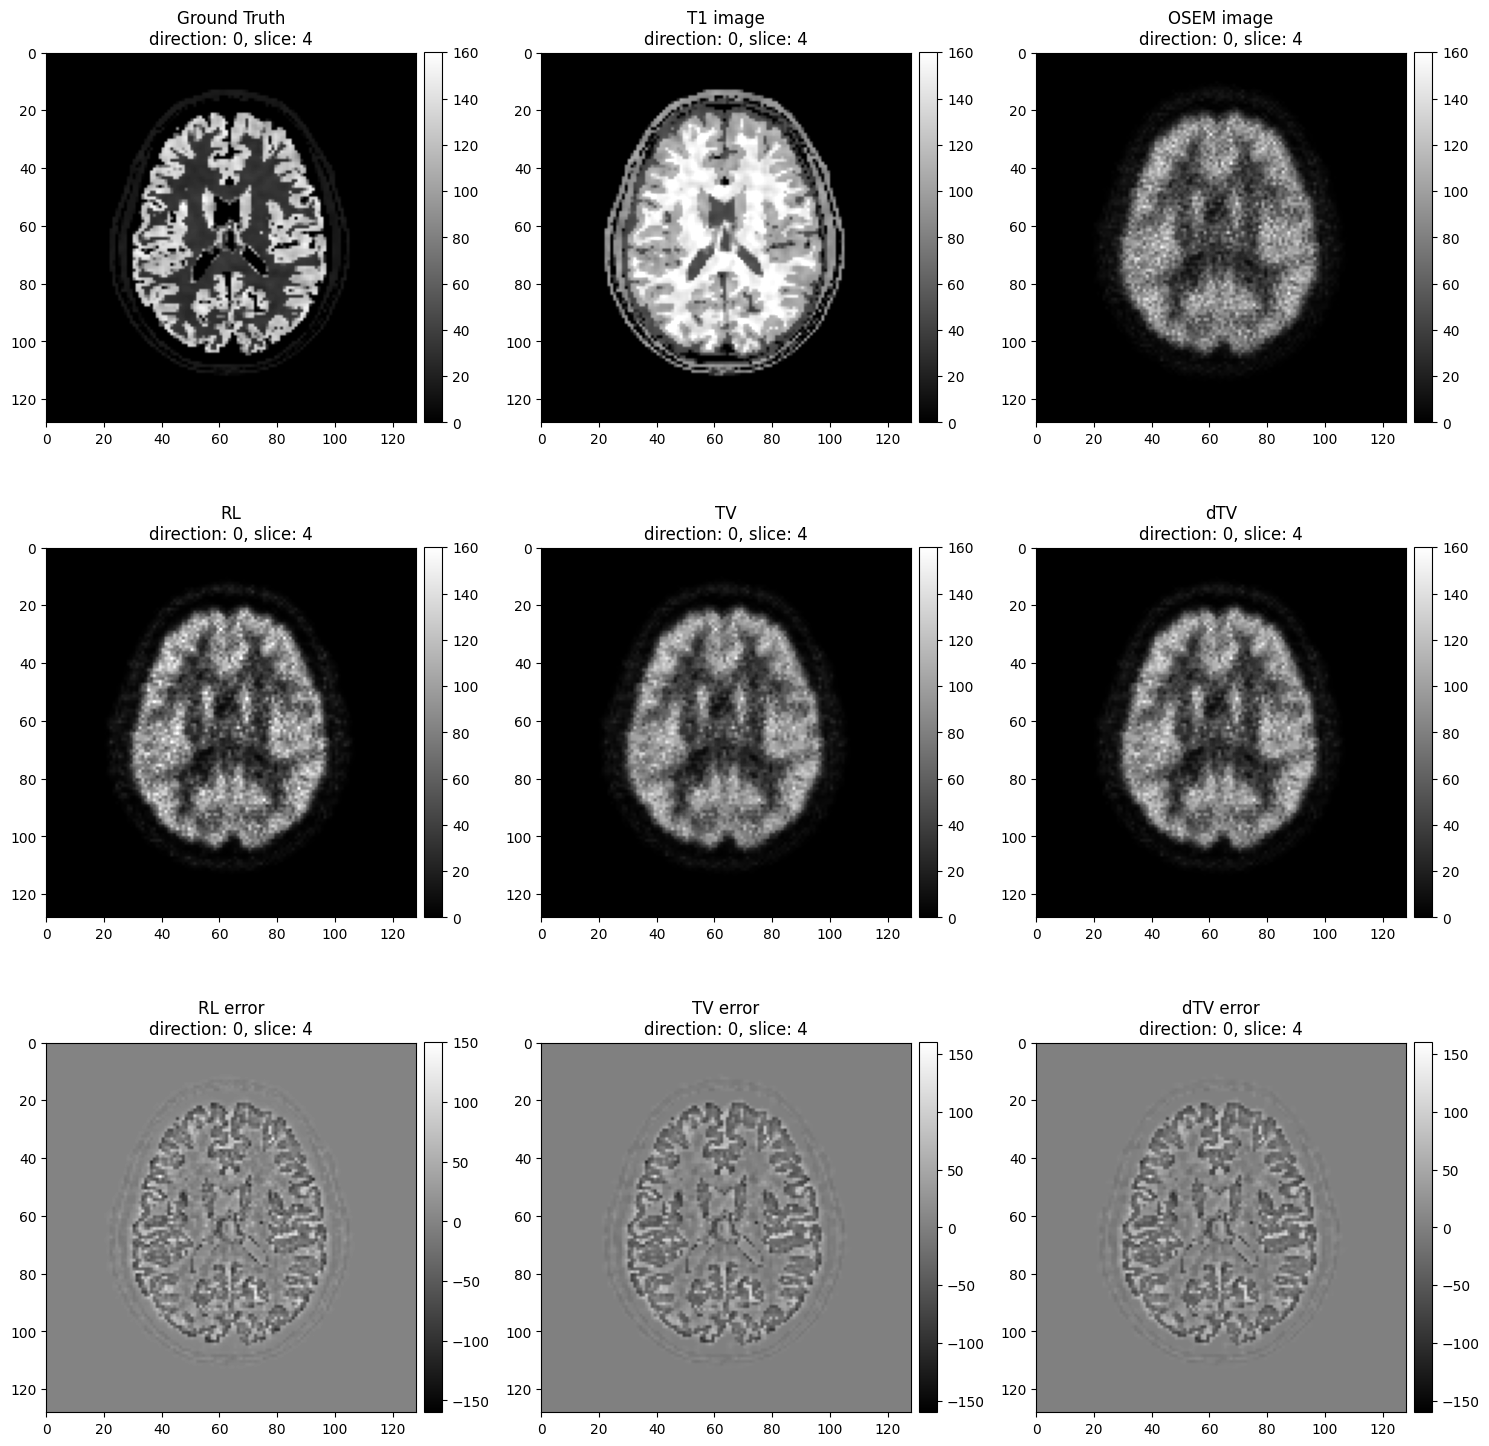

In [31]:
show2D([image_dict['PET'], image_dict['T1'], image_dict['OSEM'], deconvolved_5iter, maprl.solution, maprl_dtv.solution, deconvolved_5iter-image_dict['PET'], pdhg.solution-image_dict['PET'], pdhg_dtv.solution-image_dict['PET']], 
       title = ['Ground Truth', 'T1 image', 'OSEM image', 'RL', 'TV', 'dTV', 'RL error', 'TV error', 'dTV error'], origin = 'upper', num_cols = 3, fix_range=[(0, 160),(0, 160),(0, 160),(0, 160),(0, 160),(0, 160),(-160, 180),(-160, 160),(-160, 160)])

In [32]:
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import structural_similarity as ssim

# find mse of each image in area overlapping umap
def rmse_overlap(image1, image2, mask=None):
    if mask is None:
        return np.sqrt(mse(image1.as_array(), image2.as_array()))
    mask = mask.as_array() > 0
    return np.sqrt(mse(image1.as_array()[mask], image2.as_array()[mask]))

# find ssim of each image in area overlapping umap
def ssim_overlap(image1, image2, mask=None):
    if mask is None:
        return ssim(image1.as_array(), image2.as_array())
    mask = mask.as_array() > 0
    return ssim(image1.as_array()[mask], image2.as_array()[mask])

print("RMSE")
print(f"RL 5 iter: {rmse_overlap(deconvolved_5iter, image_dict['PET'])}")
print(f"RL 20 iter: {rmse_overlap(deconvolved_20iter, image_dict['PET'])}")
print(f"RL 50 iter: {rmse_overlap(deconvolved_50iter, image_dict['PET'])}")
print(f"TV: {rmse_overlap(maprl.solution, image_dict['PET'])}")
print(f"dTV: {rmse_overlap(maprl_dtv.solution, image_dict['PET'])}")

print("SSIM")
print(f"RL 5 iter: {ssim_overlap(deconvolved_5iter, image_dict['PET'])}")
print(f"RL 20 iter: {ssim_overlap(deconvolved_20iter, image_dict['PET'])}")
print(f"RL 50 iter: {ssim_overlap(deconvolved_50iter, image_dict['PET'])}")
print(f"TV: {ssim_overlap(maprl.solution, image_dict['PET'])}")
print(f"dTV: {ssim_overlap(maprl_dtv.solution, image_dict['PET'])}")

RMSE
RL 5 iter: 21.000696498693312
RL 20 iter: 21.356136212557605
RL 50 iter: 23.67913093310002
TV: 20.815446693815446
dTV: 20.793962657259257
SSIM
RL 5 iter: 0.7078436627698418
RL 20 iter: 0.7170160292939642
RL 50 iter: 0.6977579795997839
TV: 0.6877560254673257
dTV: 0.6902043181429002


In [33]:
# run python3 amyloid.py to generate an additional OSEM image

subprocess.run(['python3', 'amyloid.py', f'--bw_seed={bw_seed}', f'--noise_seed={noise_seed}'])


Going ahead anyway.
no additive term added
applying unnormalisation...ok
no background term added

Going ahead anyway.



CompletedProcess(args=['python3', 'amyloid.py', '--bw_seed=1337', '--noise_seed=5'], returncode=0)

In [34]:
image_dict['OSEM_amyloid'] = pet.ImageData(os.path.join('data', f'OSEM_amyloid_b{bw_seed}_n{noise_seed}.hv'))
image_dict['PET_amyloid'] = pet.ImageData(os.path.join('data', f'PET_amyloid_b{bw_seed}.hv'))

In [35]:
# monkey patching
def allocate(self, value=0):
    ''' So we can create an empty BlockDataContainer '''
    out = self.clone()
    for el in out.containers:
        el.fill(value)
    return out

cil.BlockDataContainer.allocate = allocate
    
def new(cls, *args, **kwargs):
    ''' So that a shape=(1,1) BlockDataContainer is just a DataContainer'''
    instance = super(cil.BlockDataContainer, cls).__new__(cls) 
    instance.__init__(*args, **kwargs)

    if getattr(instance, 'shape', None) == (1, 1):
        return cls.containers[0] 
    return instance

cil.BlockDataContainer.__new__ = staticmethod(new)

class bdc_FOV_filter(pet.TruncateToCylinderProcessor):
    ''' A class to apply the FOV filter to each element of a BlockDataContainer '''
    def apply(self, bdc):
        for el in bdc.containers:
            super().apply(el)

In [58]:
class JointOperator(op.LinearOperator):
    ''' Class to be used for Joint Total Variation '''
    def __init__(self, domain_geometry, operators, weights = [1,1], **kwargs):
        self.operators = operators
        self.weights = weights
        range_containers = [container for op in operators for container in op.range_geometry().allocate().containers]
        super().__init__(domain_geometry, range_geometry=cil.BlockGeometry(*range_containers), **kwargs)
        
    def direct(self, x, out=None):
        result_containers = []
        for w, operator, element in zip(self.weights, self.operators, x.containers):
            result_containers.extend(operator.direct(w*element).containers)
        return cil.BlockDataContainer(*result_containers)

    def adjoint(self, y, out=None):
        result_containers = []
        start_idx = 0
        for w, operator in zip(self.weights, self.operators):
            num_containers = len(operator.range_geometry().allocate())
            end_idx = start_idx + num_containers
            sub_containers = y.containers[start_idx:end_idx]
            adjoint_result = operator.adjoint(cil.BlockDataContainer(*sub_containers))
            result_containers.append(adjoint_result/w)
            start_idx = end_idx
        return cil.BlockDataContainer(*result_containers)
    

In [62]:
initial_estimate = cil.BlockDataContainer(image_dict['OSEM'], image_dict['OSEM_amyloid'])

zero_operator_im2im = op.ZeroOperator(image_dict['PET'])
zero_operator_im2grad = op.ZeroOperator(image_dict['PET'], grad_ref)

A = op.BlockOperator(convolve, zero_operator_im2im, zero_operator_im2im, convolve, shape=(2, 2))

K = op.BlockOperator(grad, zero_operator_im2grad, zero_operator_im2grad, grad, shape=(2, 2))

f1 = fn.OperatorCompositionFunction(fn.KullbackLeibler(b=image_dict['OSEM'], eta=image_dict['OSEM'].get_uniform_copy(1e-6)), convolve)
f2 = fn.OperatorCompositionFunction(fn.KullbackLeibler(b=image_dict['OSEM_amyloid'], eta=image_dict['OSEM_amyloid'].get_uniform_copy(1e-6)), convolve)

F = fn.BlockFunction(f1, f2)
G = fn.OperatorCompositionFunction(alpha * fn.SmoothMixedL21Norm(epsilon=1e-4), JointOperator(initial_estimate, [grad, grad],[0.25,0.75]))

maprl_synergistic = MAPRL(initial_estimate=initial_estimate, data_fidelity=F, prior=G,
                step_size=1, relaxation_eta=0.1, max_iteration=100, update_objective_interval=10)
maprl_synergistic.FOV_filter = bdc_FOV_filter()

In [63]:
maprl_synergistic.run(verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          1.91038e+05
       10        100         2.574          1.65945e+05
       20        100         2.571          1.64120e+05
       30        100         2.565          1.63252e+05
       40        100         2.558          1.62715e+05
       50        100         2.568          1.62339e+05
       60        100         2.575          1.62057e+05
       70        100         2.580          1.61836e+05
       80        100         2.570          1.61655e+05
       90        100         2.543          1.61504e+05
      100        100         2.550          1.61376e+05
-------------------------------------------------------
      100        100         2.550          1.61376e+05
Stop criterion has been reached.



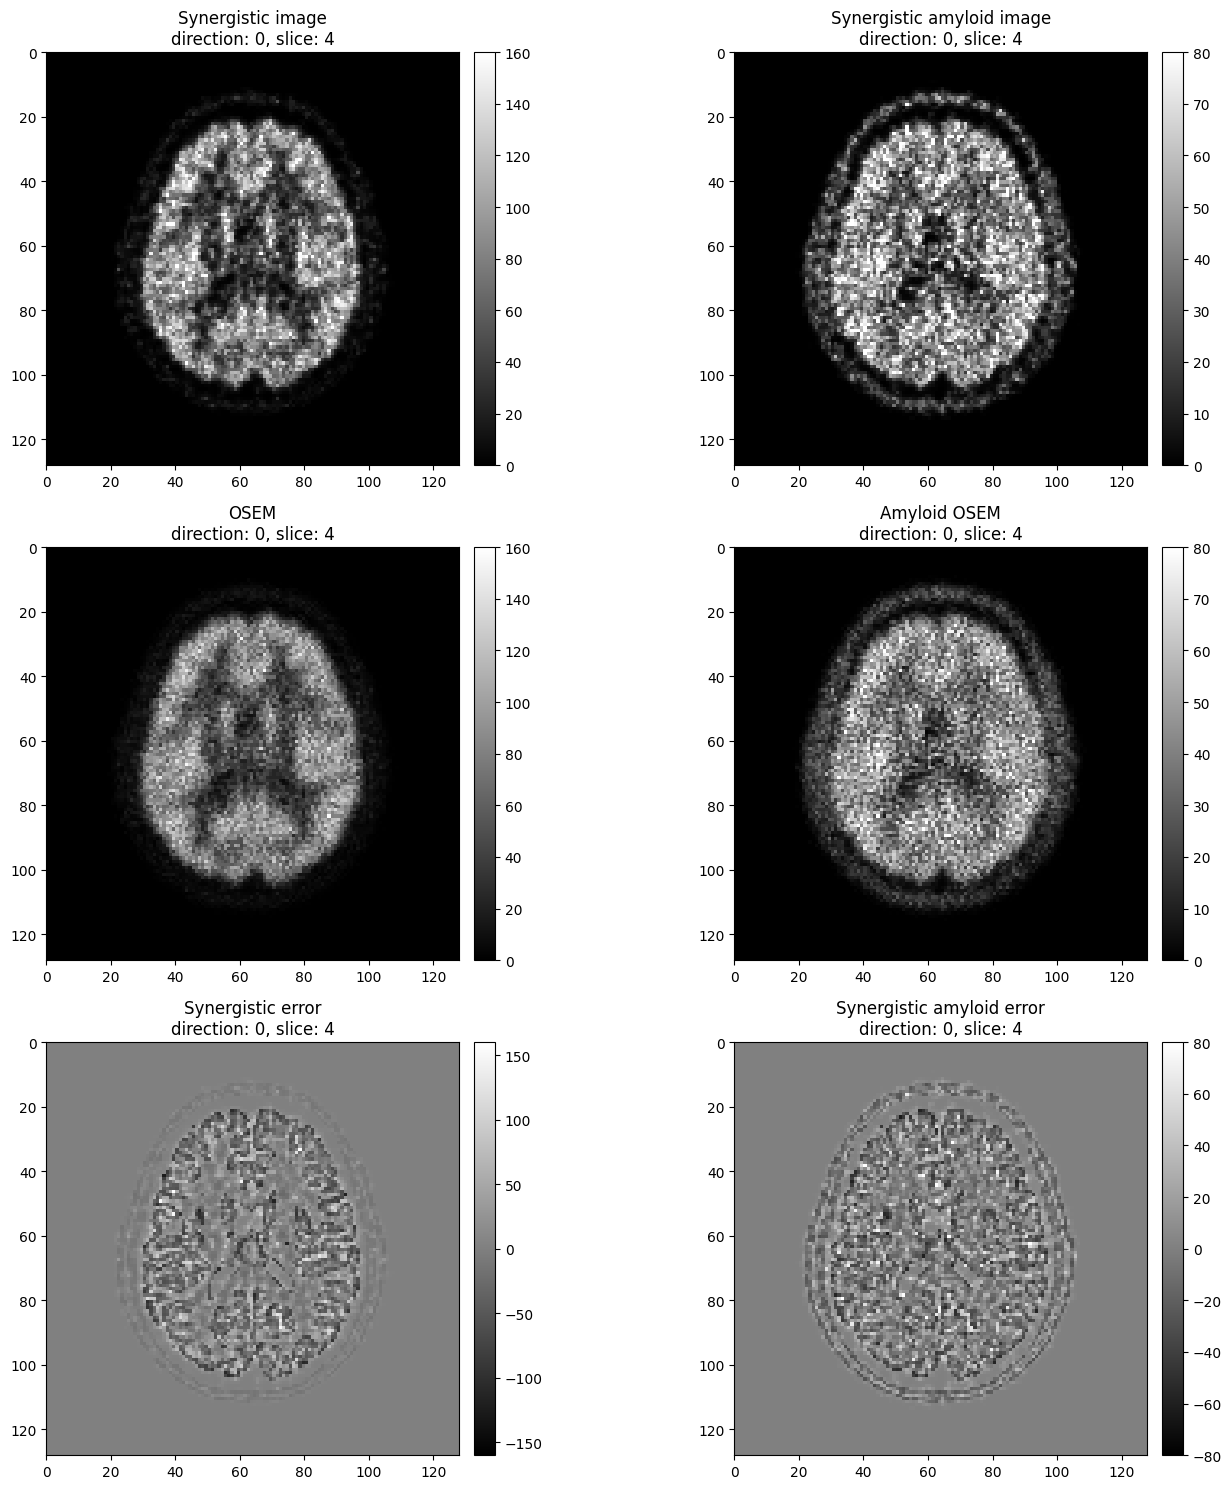

Text(0, 0.5, 'Objective Function Value')

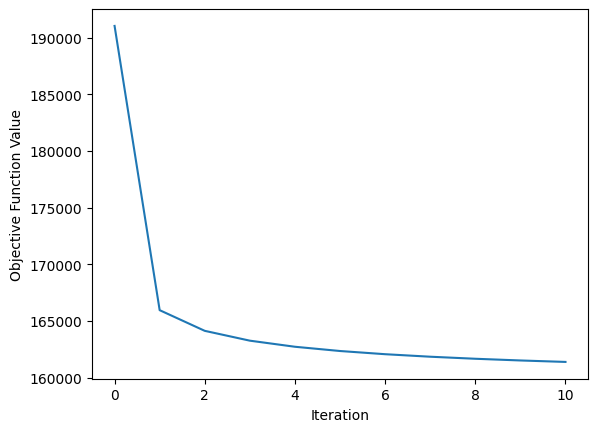

In [65]:
show2D([maprl_synergistic.solution.containers[0], maprl_synergistic.solution.containers[1], image_dict['OSEM'], image_dict['OSEM_amyloid'], 
        maprl_synergistic.solution.containers[0]-image_dict['PET'], maprl_synergistic.solution.containers[1]-image_dict['PET_amyloid']], 
            title = ['Synergistic image', 'Synergistic amyloid image', 'OSEM', 'Amyloid OSEM', 'Synergistic error', 'Synergistic amyloid error'],
            origin = 'upper', num_cols = 2, fix_range=[(0,160), (0,80), (0,160), (0,80), (-160,160), (-80,80)])

plt.plot(maprl_synergistic.objective)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')


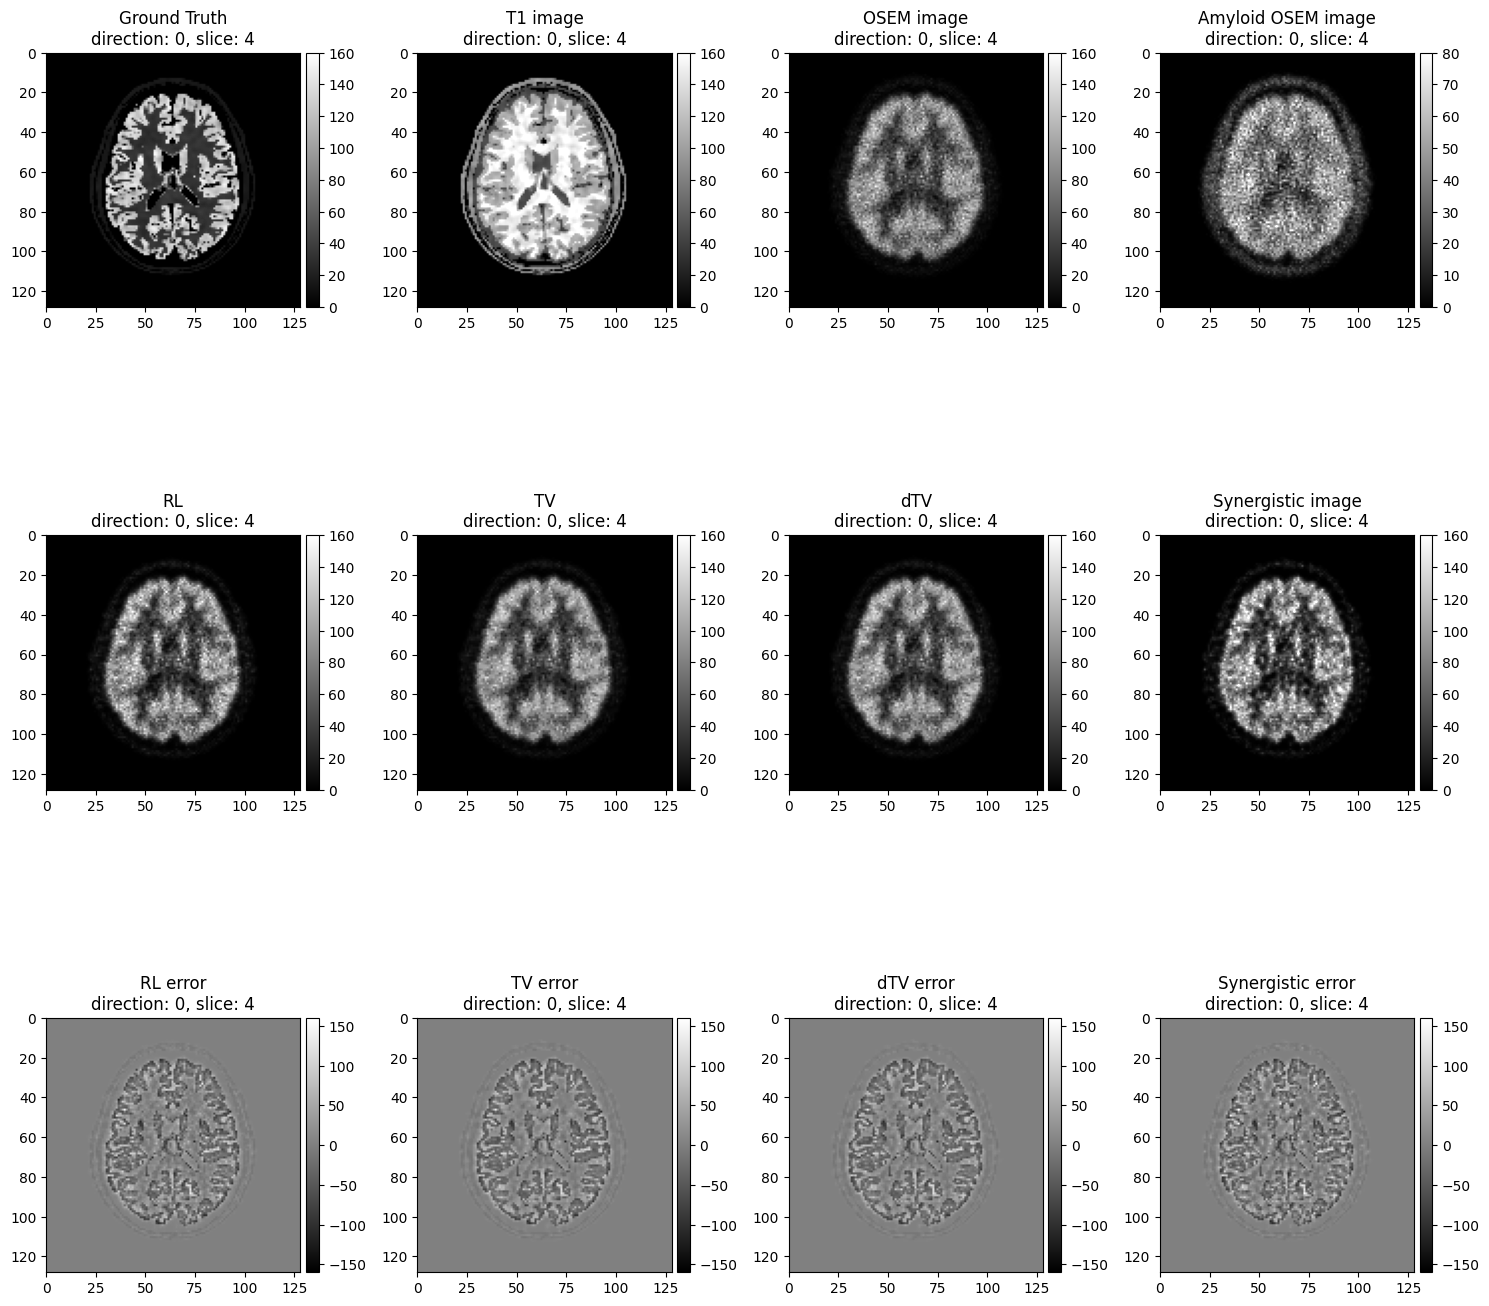

In [66]:
# show all iamges and differences
show2D([image_dict['PET'], image_dict['T1'], image_dict['OSEM'], image_dict['OSEM_amyloid'], deconvolved_5iter, maprl.solution, maprl_dtv.solution, maprl_synergistic.solution.containers[0], deconvolved_5iter-image_dict['PET'], pdhg.solution-image_dict['PET'], pdhg_dtv.solution-image_dict['PET'], maprl_synergistic.solution.containers[0]-image_dict['PET']],
         title = ['Ground Truth', 'T1 image', 'OSEM image', 'Amyloid OSEM image', 'RL', 'TV', 'dTV', 'Synergistic image', 'RL error', 'TV error', 'dTV error', 'Synergistic error', ], origin = 'upper', num_cols = 4, 
         fix_range=[(0, 160),(0, 160),(0, 160),(0, 80),(0, 160),(0, 160),(0, 160),(0, 160),(-160, 160),(-160, 160),(-160, 160),(-160, 160)])

In [67]:
print("RMSE")
print(f"RL 5 iter: {rmse_overlap(deconvolved_5iter, image_dict['PET'])}")
print(f"RL 20 iter: {rmse_overlap(deconvolved_20iter, image_dict['PET'])}")
print(f"RL 50 iter: {rmse_overlap(deconvolved_50iter, image_dict['PET'])}")
print(f"TV: {rmse_overlap(maprl.solution, image_dict['PET'])}")
print(f"dTV: {rmse_overlap(maprl_dtv.solution, image_dict['PET'])}")
print(f"Synergistic: {rmse_overlap(maprl_synergistic.solution[0], image_dict['PET'])}")

print("SSIM")
print(f"RL 5 iter: {ssim_overlap(deconvolved_5iter, image_dict['PET'])}")
print(f"RL 20 iter: {ssim_overlap(deconvolved_20iter, image_dict['PET'])}")
print(f"RL 50 iter: {ssim_overlap(deconvolved_50iter, image_dict['PET'])}")
print(f"TV: {ssim_overlap(maprl.solution, image_dict['PET'])}")
print(f"dTV: {ssim_overlap(maprl_dtv.solution, image_dict['PET'])}")
print(f"Synergistic: {ssim_overlap(maprl_synergistic.solution[0], image_dict['PET'])}")

RMSE
RL 5 iter: 21.000696498693312
RL 20 iter: 21.356136212557605
RL 50 iter: 23.67913093310002
TV: 20.815446693815446
dTV: 20.793962657259257
Synergistic: 21.630332460417893
SSIM
RL 5 iter: 0.7078436627698418
RL 20 iter: 0.7170160292939642
RL 50 iter: 0.6977579795997839
TV: 0.6877560254673257
dTV: 0.6902043181429002
Synergistic: 0.7150683448348126
